In [1]:
import requests # Загрузка новостей с сайта.
from bs4 import BeautifulSoup # Превращалка html в текст.
import re # Регулярные выражения.
import pandas as pd
from datetime import date
from datetime import timedelta
import nltk
import nltk.data
from tqdm.notebook import tqdm
from gensim.models.word2vec import Word2Vec
import pymorphy2
%matplotlib inline
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors # Семантические вектора.
import numpy as np
from umap import UMAP
# from numba import jit
from sklearn.manifold import TSNE
from matplotlib.pyplot import figure
from sklearn.cluster import DBSCAN
import seaborn as sns
from matplotlib.colors import ListedColormap
from numpy.random import choice
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans

# Выгрузка новостей с сайта

In [3]:
# Получение ссылок новостей за день
def get_news_for_day(day):
    links = []
    
    url_root = 'http://tramuk.ru'
    url = url_root + '/date/' + str(day.year) + '/' + str(day.month) + '/' + str(day.day) + '.html'
    # Теперь выделим только то, что взято в тег h2.
    h2s=BeautifulSoup(requests.get(url).text, "html5lib").find_all("h2")
    # Формируем список ссылок. Для этого берем первую (кстати, единственную) ссылку из каждого выделенного
    # фрагмента, у нее берем значение параметра href. Так как ссылки внутренние, добавляем к ним адрес сайта.
    links=["http://tramuk.ru"+l.find_all("a")[0]["href"] for l in h2s]
    return links

In [4]:
# Получение новостей по ссылке
def get_news_text(url):
    page_text = requests.get(url).text
    bs=BeautifulSoup(page_text, "html5lib")
    title = None
    # Заголовок
    title = bs.h1.text
    # Сам текст
    whole_text = bs.find_all('div', 'itemBody')
    text = None
    for i in range(len(whole_text)):
        text = " ".join([p.text for p in whole_text[i].find_all("p")])
        if not text:
            text = " ".join(whole_text[i].text.split('\n\n'))
    return {'title': title, 
            'text': text}

In [5]:
# Запись в уже октрытый файл
def save_text_to_file(file, data, date):
    title = str(data['title']).encode().decode('utf-8')
    text = str(data['text']).encode().decode('utf-8')
    text = text.strip('\n')
    text = text.strip()
    file.write('\n=====\n'+title)
    file.write('\n' + str(date.year) + '/' + str(date.month) + '/' + str(date.day))
    file.write('\n-----\n'+text)

In [6]:
%%time
filename = 'text2.txt'
file=open(filename, 'w', encoding='utf-8')
file.close()
begin_date = date(2015, 1, 1)
itr = begin_date
delta = timedelta(days=1)
# end_date = date.today() + delta
end_date = date.today()
sum_days = end_date - begin_date
file=open(filename, 'a', encoding='utf-8')
while itr != end_date:
    likns = []
    link_list = get_news_for_day(itr)
    for i in range(len(link_list)):
        try:
            data = get_news_text(link_list[i])
            save_text_to_file(file, data, itr)
        except Exception as err:
            print(err)
            print('Date: ' + str(itr))
            print('step: ' + str((itr - begin_date).days))
    print(str((itr - begin_date).days)+"/"+str((sum_days-delta).days), end='\r')
    
    itr += delta
    
file.close()
print(str((itr - begin_date).days)+"/"+str((sum_days-delta).days), end='\r')
print('Success!!!\n')

HTTPConnectionPool(host='tramuk.ru', port=80): Max retries exceeded with url: /novosti/novosti/7308-ust-katav-s-bolshim-perevesom-golosov-vybral-alekseya-tekslera.html (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0D1F7F70>: Failed to establish a new connection: [WinError 10060] Попытка установить соединение была безуспешной, т.к. от другого компьютера за требуемое время не получен нужный отклик, или было разорвано уже установленное соединение из-за неверного отклика уже подключенного компьютера'))
Date: 2019-09-09
step: 1712


ConnectionError: HTTPConnectionPool(host='tramuk.ru', port=80): Max retries exceeded with url: /date/2020/1/11.html (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0CF47820>: Failed to establish a new connection: [WinError 10060] Попытка установить соединение была безуспешной, т.к. от другого компьютера за требуемое время не получен нужный отклик, или было разорвано уже установленное соединение из-за неверного отклика уже подключенного компьютера'))

In [55]:
newsfile = open('text2.txt', 'r', encoding='utf-8')
text_news = [(n.split("\n-----\n")[0].split('\n\n\n')[0], 
              n.split("\n-----\n")[0].split('\n')[1], 
              n.split("\n-----\n")[1]) for n in newsfile.read().split("\n=====\n")[1:]]
news = pd.DataFrame(text_news, columns = ['Header', 'Date', 'News'])
newsfile.close()

In [56]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4641 entries, 0 to 4640
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Header  4641 non-null   object
 1   Date    4641 non-null   object
 2   News    4641 non-null   object
dtypes: object(3)
memory usage: 54.4+ KB


In [57]:
news.tail()

,Header,Date,News
4636,\n\t\t\t\t\t \n\t\t\t\tРаботники УКВЗ подвели...,\t\t\t\t\t,В последних числах декабря 2019 года в ДК им. ...
4637,\n\t\t\t\t\t \n\t\t\t\tУстькатавцы выбирают с...,\t\t\t\t\t,И это фраза не для красивого словца. Еще не ус...
4638,\n\t\t\t\t\t \n\t\t\t\tПолицейские принимали ...,\t\t\t\t\t,"Ребята «Центра помощи детям, оставшимся без по..."
4639,\n\t\t\t\t\t \n\t\t\t\tБиблиотеки Усть-Катава...,\t\t\t\t\t,"Наша землячка, на сегодняшний день проживающая..."
4640,\n\t\t\t\t\t \n\t\t\t\tВ Усть-Катаве отметили...,\t\t\t\t\t,8 января в Городском Дворце культуры прошёл тр...


# Построение модели по тексту

In [29]:
texts = list(news['News'])

In [33]:
tmp_dict2 = {} # Кеш значимых слов.

morph = pymorphy2.MorphAnalyzer()

# Фильтруем по части речи и возвращаем только начальную форму.
def normalizePymorphy2(text):
    output = []
    # Делим на предложения самым страшным из возможных образов.
    sentences = text.split('.')
    for sentence in sentences:
        tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', sentence)
        # Берем предложения не менее чем из 5 слов.
        if len(tokens)<=4:
            continue
        words = []
        for t in tokens:
            # Если токен уже был закеширован, быстро возьмем результат из него.
            if t in tmp_dict2.keys():
                words.append(tmp_dict2[t])
            # Слово еще не встретилось, будем проводить медленный морфологический анализ.
            else:
                pv = morph.parse(t)
                if pv[0].tag.POS != None:
                    word = pv[0].normal_form+"_"+pv[0].tag.POS
                    # Отправляем слово в результат, ...
                    words.append(word)
                    # ... и кешируем результат его разбора.
                    tmp_dict2[t] = word
        output.append(words)
                    
    return output

In [34]:
all_sentences = []
for text in tqdm(texts):
    all_sentences.extend(normalizePymorphy2(text))

In [35]:
%%time

# список параметров, которые можно менять по вашему желанию
num_features = 50  # итоговая размерность вектора каждого слова
min_word_count = 5  # минимальная частотность слова, чтобы оно попало в модель
num_workers = 4     # количество ядер вашего процессора, чтоб запустить обучение в несколько потоков
context = 10        # размер окна 
downsampling = 1e-3 # внутренняя метрика модели

model = Word2Vec(all_sentences, workers=num_workers, size=num_features,
                 min_count=min_word_count, window=context, sample=downsampling)

Wall time: 13.1 s


In [36]:
model.init_sims(replace=True)

In [37]:
# Посмотрим на самые похожие слова.
model.wv.most_similar('система_NOUN')

[('отход_NOUN', 0.8811246156692505),
 ('технический_ADJF', 0.8737788796424866),
 ('коммунальный_ADJF', 0.866409957408905),
 ('ресурс_NOUN', 0.8642325401306152),
 ('существующий_ADJF', 0.8577613830566406),
 ('объект_NOUN', 0.8566582798957825),
 ('повышение_NOUN', 0.8547373414039612),
 ('услуга_NOUN', 0.8521535992622375),
 ('соответствовать_PRTF', 0.8510845303535461),
 ('выброс_NOUN', 0.8500745296478271)]

In [38]:
model.corpus_total_words

1268680

In [59]:
# Список значимых частей речи.
conv_pos = {'ADJF':'ADJ', 'ADJS':'ADJ', 'ADV':'ADV', 'NOUN':'NOUN', 'VERB':'VERB'}

tmp_dict = {}
nones = {}

# Фильтруем по части речи и возвращаем только начальную форму.
def normalizePymorphy3(text):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        if t in tmp_dict.keys():
            words.append(tmp_dict[t])
        elif t in nones.keys():
            pass
        else:
            pv = morph.parse(t)
            if pv[0].tag.POS != None:
                if pv[0].tag.POS in conv_pos.keys():
                    words.append(pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS])
                    tmp_dict[t] = pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS]
                else:
                    nones[t] = ""
                    
    return words

In [60]:
print(model.vector_size)
print(len(model.wv.index2word))

50
14436


In [61]:
index2word_set = set(model.wv.index2word)
def text_to_vec(text):
    text_vec = np.zeros((model.vector_size,), dtype="float32")
    n_words = 0

    for word in normalizePymorphy3(text):
        if word in index2word_set:
            n_words = n_words + 1
            text_vec = np.add(text_vec, model[word]) 
    
    if n_words != 0:
        text_vec /= n_words
    return text_vec

In [62]:
vectors = [text_to_vec(text) for text in news.News]

<ipython-input-61-d141af342243>:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  text_vec = np.add(text_vec, model[word])


In [68]:
vpos=1
v1 = text_to_vec(news.News[vpos])

ms = np.argmin([np.linalg.norm(v1-vectors[i]) for i in range(news.News.shape[0]) if i!=vpos])
if ms>vpos:
    print(ms+1, news.News[ms+1])
else:
    print(ms, news.News[ms])

204 12 марта в Законодательном Собрании Челябинской области состоялась церемония вручения премии ЗСО работникам жилищно-коммунального хозяйства. Среди награждённых устькатавец Александр Александров. В 2012 году в Законодательном Собрании Челябинской области зародилась прекрасная традиция - чествовать лучших работников жилищно-коммунального хозяйства накануне их профессионального праздника. Подобные премии ЗСО уже давно существуют в других профессиональных сферах. 12 марта премии вручали первый заместитель председателя Законодательного Собрания Юрий Карликанов и депутат Николай Янов. - Жилищно-коммунальное хозяйство справедливо называют отраслью жизнеобеспечения, - в своём приветственном слове отметил Юрий Карликанов. - Ведь именно работники ЖКХ обеспечивают комфортные условия проживания нашим жителям, стабильную и бесперебойную работу предприятий и учреждений региона. Постановлением Законодательного Собрания Челябинской области от 28.01.2015 года № 2445 за высокое профессиональное маст

<ipython-input-61-d141af342243>:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  text_vec = np.add(text_vec, model[word])


In [69]:
news.News[vpos]

'В конце минувшего года преподаватель Усть-Катавского\xa0техникума получила почётную грамоту ЗСО. По информации помощника депутата ЗСО Аллы Кривошеевой, 30 декабря в актовом зале индустриально-технологического техникума депутат Законодательного собрания области Марат Новичков вручил преподавателю специальных дисциплин Татьяне Федосовой почётную грамоту Заксобрания за значительный вклад в образовательную систему Усть-Катавского городского округа и многолетний добросовестный труд, а также денежную премию в размере 10 тысяч рублей. Во время поздравления Марат Леонидович отметил, что в уходящем году отмечалось 85-летие профессионального образования в городе Усть-Катаве, и Заксобрание области не могло обойти вниманием такое знаменательное событие. В заключение своего выступления депутат пожелал всем присутствующим здоровья, добра, мира и благоденствия.'

# Использование готовой модели

In [2]:
model_w2v = KeyedVectors.load_word2vec_format('Data/araneum_upos_skipgram_300_2_2018.vec.gz')

In [3]:
# Список значимых частей речи.
conv_pos = {'ADJF':'ADJ', 'ADJS':'ADJ', 'ADV':'ADV', 'NOUN':'NOUN', 'VERB':'VERB'}

tmp_dict = {}
nones = {}

morph = pymorphy2.MorphAnalyzer()

# Фильтруем по части речи и возвращаем только начальную форму.
def normalizePymorphy3(text):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        if t in tmp_dict.keys():
            words.append(tmp_dict[t])
        elif t in nones.keys():
            pass
        else:
            pv = morph.parse(t)
            if pv[0].tag.POS != None:
                if pv[0].tag.POS in conv_pos.keys():
                    words.append(pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS])
                    tmp_dict[t] = pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS]
                else:
                    nones[t] = ""
                    
    return words

In [4]:
print(model_w2v.vector_size)
print(len(model_w2v.index2word))

300
196620


In [5]:
index2word_set = set(model_w2v.index2word)

def text_to_vec(text):
    text_vec = np.zeros((model_w2v.vector_size,), dtype="float32")
    n_words = 0

    for word in normalizePymorphy3(text):
        if word in index2word_set:
            n_words = n_words + 1
            text_vec = np.add(text_vec, model_w2v[word]) 
    
    if n_words != 0:
        text_vec /= n_words
    return text_vec

In [6]:
with open("Data/text2.txt", encoding="utf-8") as newsfile: # Файл с новостями.
    text = newsfile.read()
    div_text = text.split("\n=====\n")[1:]
    text_news = [(n.split("\n-----\n")[0].split('\n\n\n')[0],
                  n.split('\n')[1],
                  n.split('\n')[2], 
                  '\n'.join(n.split('\n')[3:])) 
                 for n in div_text]
    news = pd.DataFrame(text_news, columns = ['Header', 'Date', 'Tag', 'News'])

In [7]:
news.head()

,Header,Date,Tag,News
0,\n\t\t\t\t\t \n\t\t\t\tМолодежь приглашают ра...,\t\t\t\t\t,\t\t\t\tМолодежь приглашают рассказать о своем...,\t\t\t\t\t \n\t\t\t\n2015/1/12\n-----\nРадио ...
1,\n\t\t\t\t\t \n\t\t\t\tНовогодним подарком ст...,\t\t\t\t\t,\t\t\t\tНовогодним подарком стала грамота ЗСО\t,\t\t\t\t\t \n\t\t\t\n2015/1/12\n-----\nВ конц...
2,\n\t\t\t\t\t \n\t\t\t\tВ Челябинске прошёл че...,\t\t\t\t\t,\t\t\t\tВ Челябинске прошёл чемпионат Европы п...,\t\t\t\t\t \n\t\t\t\n2015/1/13\n-----\n10-11 ...
3,\n\t\t\t\t\t \n\t\t\t\tВ Челябинской области ...,\t\t\t\t\t,\t\t\t\tВ Челябинской области вновь спрашивают...,\t\t\t\t\t \n\t\t\t\n2015/1/13\n-----\nПрошло...
4,\n\t\t\t\t\t \n\t\t\t\tШахматисты Усть-Катава...,\t\t\t\t\t,\t\t\t\tШахматисты Усть-Катава соревновались у...,\t\t\t\t\t \n\t\t\t\n2015/1/13\n-----\nЛюбите...


In [8]:
w2v_vectors = [text_to_vec(text) for text in news.News]

In [9]:
vpos=15
v1 = text_to_vec(news.News[vpos])

ms = np.argmin([np.linalg.norm(v1-w2v_vectors[i]) for i in range(news.News.shape[0]) if i!=vpos])
if ms>vpos:
    print(ms+1, news.News[ms+1])
else:
    print(ms, news.News[ms])

4228 					  
			
2019/8/1
-----
20 июля в саткинском шахматном клубе «Вертикаль прошёл открытый блиц-турнир, посвящённый Международному дню шахмат. В соревнования приняло участие 25 шахматистов разного возраста из Сатки, Златоуста, Катав-Ивановска и Усть-Катава. Честь нашего города на этом турнире защищала 16-летняя шахматистка Дарья Филиппова. С результатом 10,5 очков из 11-ти возможных победу в турнире одержал Иван Морозов из Златоуста. Второе место с 10 набранными очками заняла Дарья Филиппова, уступившая в поединках только будущему чемпиону. Бронзовым призёром стал Владимир Король из Сатки, набравший 8,5 очков. Это не единственный областной турнир, в котором наш женский мастер ФИДЕ добилась успехов. Так, в июне в Челябинске состоялся 14-ый традиционный турнир по быстрым шахматам, посвящённый памяти председателя Законодательного Собрания Челябинской области Виктора Давыдова. В соревнованиях приняло участие более 130-ти спортсменов из Челябинской, Свердловской и Ростовской областей. 

In [10]:
news.News[vpos]

'\t\t\t\t\t  \n\t\t\t\n2015/1/15\n-----\nВ Сатке завершила свою работу 25-я сессия школы десятого чемпиона мира Б. Спасского. По её окончанию участники померились силами в турнире по быстрым шахматам. Как сообщает шахматный клуб «Вертикаль», школа Бориса Спасского действует в Сатке с 2003 года. Её зимняя и летняя сессии - главные учебно-тренировочные сборы юных шахматистов Уральского федерального округа. Лекции, семинары и практические занятия в группах проводили международные гроссмейстеры Игорь Хенкин (Германия) и Руслан Щербаков, международный мастер, заслуженный тренер России по шахматам Александр Филипенко. В рамках сессии для юных шахматистов были организованы спортивные мероприятия и соревнования на площадках лечебно-оздоровительного комплекса «ЛаВита», а также культурная программа. Завершением сессии стало участие в турнире по быстрым шахматам на Кубок главы Саткинского муниципального района 11 января. Этот престижный турнир собрал 121-ого участника разного возраста и уровня по

# Кластеризация векторов новостей

In [82]:
umap_news=UMAP()
# umaped_vct=umap_news.fit_transform(w2v_vectors) НЕ РОБИТ

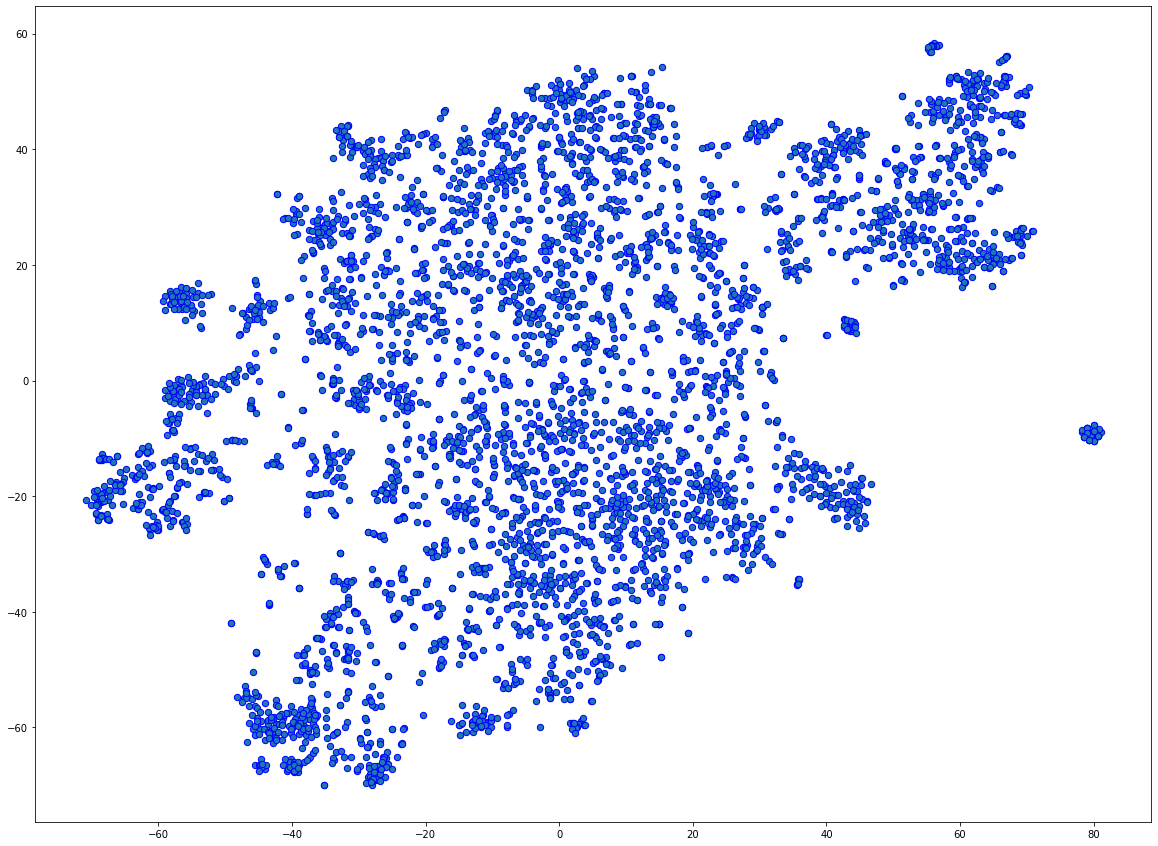

In [11]:
tsne=TSNE()
tsne_vct = tsne.fit_transform(w2v_vectors)

fig, ax = plt.subplots(figsize=(20, 15))
ax.scatter(tsne_vct[:, 0], tsne_vct[:, 1], 
           cmap=plt.cm.autumn, edgecolor='b', s=40)
plt.show()

## Кластеризация DBSCAN

### Информация о кластерах

Оценим расстояние эпсилон

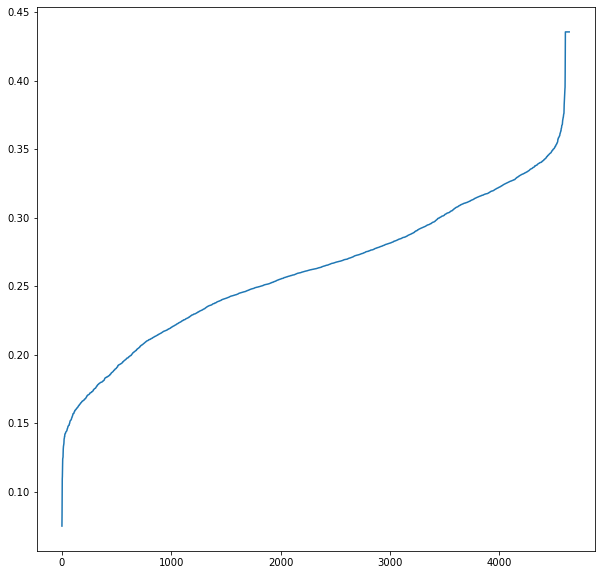

In [18]:
wm = kneighbors_graph(w2v_vectors, 3, n_jobs=-1)
nzr, nzc = wm.nonzero()
neighbours = np.zeros(len(w2v_vectors))
for r, c in zip(nzr, nzc):
    neighbours[r] += np.linalg.norm(v1-w2v_vectors[c])
    
neighbours=sorted(neighbours/3)
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(range(len(neighbours)), neighbours)
plt.show()

Возьмём эпсилон 0.25

120


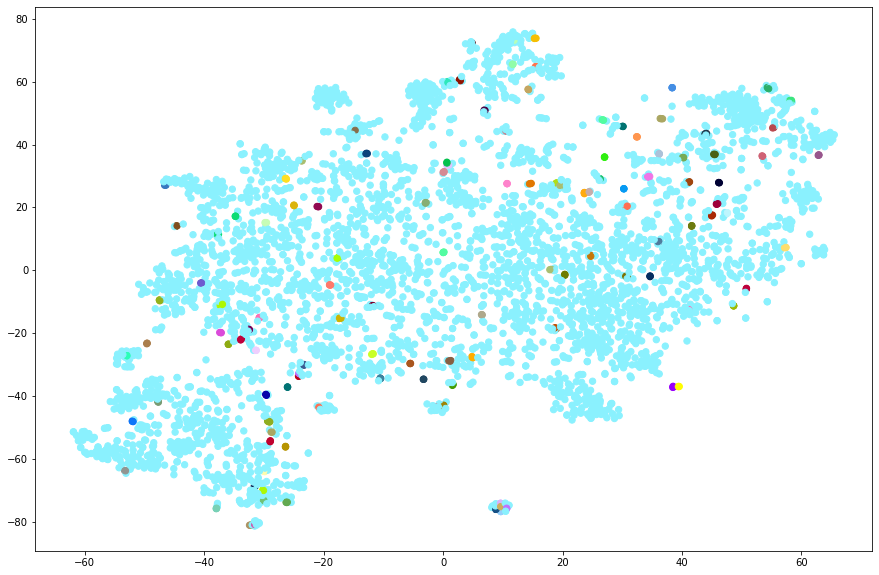

Wall time: 522 ms


In [39]:
%%time
db=DBSCAN(eps=0.25, min_samples=3)
db_clusters=db.fit_predict(tsne_vct)
myclr=ListedColormap(choice(list(sns.xkcd_rgb.values()), max(db_clusters)+1)) # Генерируем контрастную карту цветов.
print(max(db_clusters))
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(tsne_vct[:, 0], tsne_vct[:, 1], s=40, c=db_clusters, cmap=myclr)
plt.show()

In [41]:
clusters=list(set(db_clusters))

# for c in clusters:
#     print(c)
#     cntr=0
#     for i, a in enumerate(news.Header):
#         if db_clusters[i]==c:
#             print(a)
#             cntr+=1
#             if cntr==3:
#                 break

In [42]:
#Сколько всего новостей в одном кластере
for c in clusters:
    print(c, end=' ')
    cntr=0
    for i, a in enumerate(news.Header):
        if db_clusters[i]==c:
#             print(a)
            cntr+=1
#             if cntr==3:
#                 break
    print(cntr)

0 4
1 3
2 3
3 3
4 3
5 3
6 3
7 3
8 3
9 3
10 3
11 3
12 3
13 3
14 3
15 5
16 3
17 3
18 3
19 4
20 3
21 3
22 3
23 3
24 3
25 3
26 3
27 3
28 3
29 6
30 3
31 3
32 3
33 3
34 3
35 3
36 3
37 4
38 3
39 3
40 3
41 3
42 4
43 3
44 3
45 3
46 3
47 4
48 3
49 4
50 4
51 3
52 3
53 3
54 3
55 3
56 3
57 3
58 3
59 3
60 3
61 3
62 3
63 3
64 3
65 4
66 3
67 3
68 3
69 3
70 3
71 5
72 3
73 3
74 3
75 3
76 3
77 3
78 3
79 3
80 3
81 3
82 4
83 4
84 3
85 3
86 3
87 3
88 3
89 3
90 3
91 3
92 3
93 3
94 5
95 6
96 5
97 3
98 3
99 6
100 3
101 3
102 3
103 3
104 3
105 3
106 3
107 3
108 3
109 3
110 3
111 3
112 3
113 3
114 3
115 3
116 3
117 3
118 3
119 3
120 3
-1 4251


In [43]:
c = 2
cntr=0
for i, a in enumerate(news.Header):
        if db_clusters[i]==c:
            print(a)
            cntr+=1
            if cntr==3:
                break


					  
				Обжаловать решение мирового судьи не получилось	  
					  
			
2015/1/30

					  
				Водитель, оставивший место ДТП, арестован	  
					  
			
2015/1/30

					  
				Суд Усть-Катава на страже безопасности жизни детей	  
					  
			
2015/4/1


# Определение количества кластеров

Дэндограммы - количество кластеров
В "Классификации" - оценка по критериям

In [12]:
from scipy.cluster.hierarchy import linkage, dendrogram

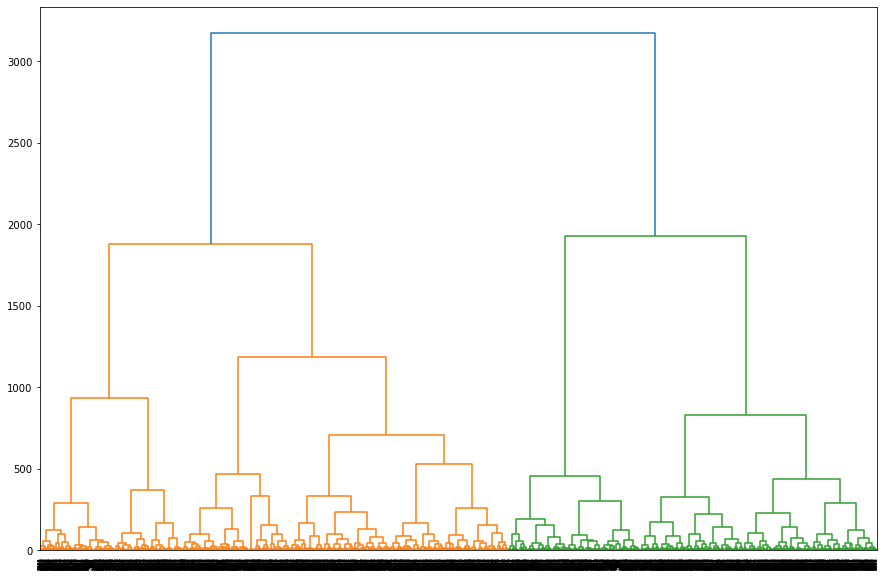

Wall time: 7min 33s


In [13]:
%%time
Y = linkage(tsne_vct, method='ward')
fig, ax = plt.subplots(figsize=(15, 10))
Z = dendrogram(Y)
plt.show()

Я насчитал около 86 кластеров, на уровне около 100 значений

85


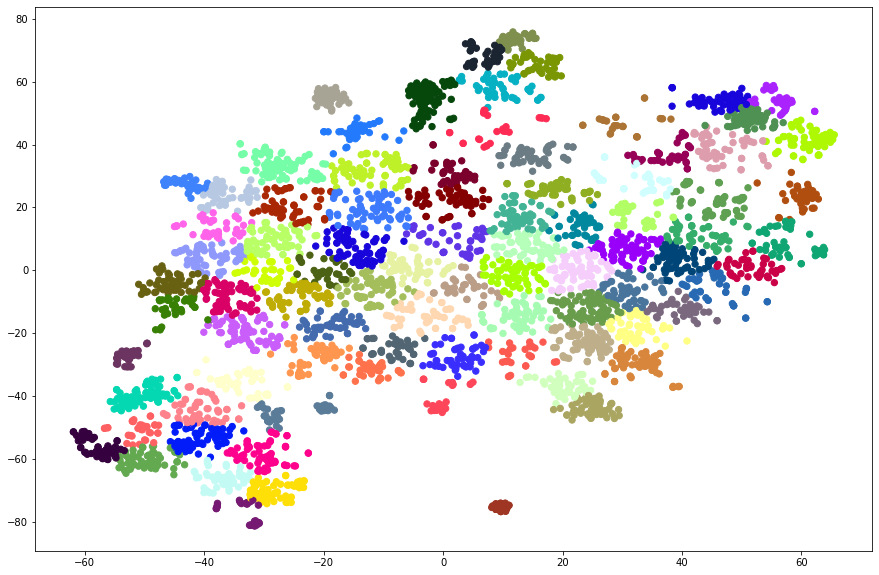

Wall time: 3.33 s


In [36]:
%%time
cluster_space_size = 86
km_clustering = KMeans(n_clusters=cluster_space_size)
km_clusters = km_clustering.fit_predict(tsne_vct)

# db=DBSCAN(eps=2, min_samples=3)
# db_clusters=db.fit_predict(tsne_vct)

myclr=ListedColormap(choice(list(sns.xkcd_rgb.values()), max(km_clusters)+1)) # Генерируем контрастную карту цветов.
print(max(km_clusters))
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(tsne_vct[:, 0], tsne_vct[:, 1], s=40, c=km_clusters, cmap=myclr)
plt.show()

In [51]:
clusters=list(set(km_clusters))

In [52]:
#Сколько всего новостей в одном кластере
for c in clusters:
    print(c, end=' ')
    cntr=0
    for i, a in enumerate(news.Header):
        if km_clusters[i]==c:
#             print(a)
            cntr+=1
#             if cntr==3:
#                 break
    print(cntr)

0 74
1 82
2 67
3 53
4 65
5 58
6 38
7 55
8 47
9 35
10 60
11 53
12 60
13 59
14 37
15 41
16 62
17 85
18 41
19 71
20 63
21 53
22 75
23 41
24 59
25 48
26 72
27 47
28 71
29 91
30 46
31 59
32 51
33 61
34 56
35 27
36 37
37 47
38 33
39 30
40 55
41 48
42 34
43 52
44 68
45 66
46 44
47 64
48 34
49 55
50 40
51 44
52 40
53 40
54 72
55 53
56 54
57 61
58 74
59 73
60 30
61 37
62 65
63 62
64 46
65 77
66 45
67 61
68 42
69 47
70 54
71 50
72 40
73 48
74 57
75 57
76 59
77 46
78 37
79 60
80 61
81 55
82 40
83 57
84 73
85 54


In [59]:
c = 82
cntr=0
for i, a in enumerate(news.Header):
        if km_clusters[i]==c:
            print(a)
            cntr+=1
            if cntr==3:
                break


					  
				Куда сходить в майские праздники?	  
					  
			
2015/4/27

					  
				26 апреля в Усть-Катаве состоялся праздник танца	  
					  
			
2015/4/28

					  
				Усть-катавские «Казачата» вернулись с творческого конкурса	  
					  
			
2015/6/5


# Метод локтя

Text(0, 0.5, 'Sum of squared distance')

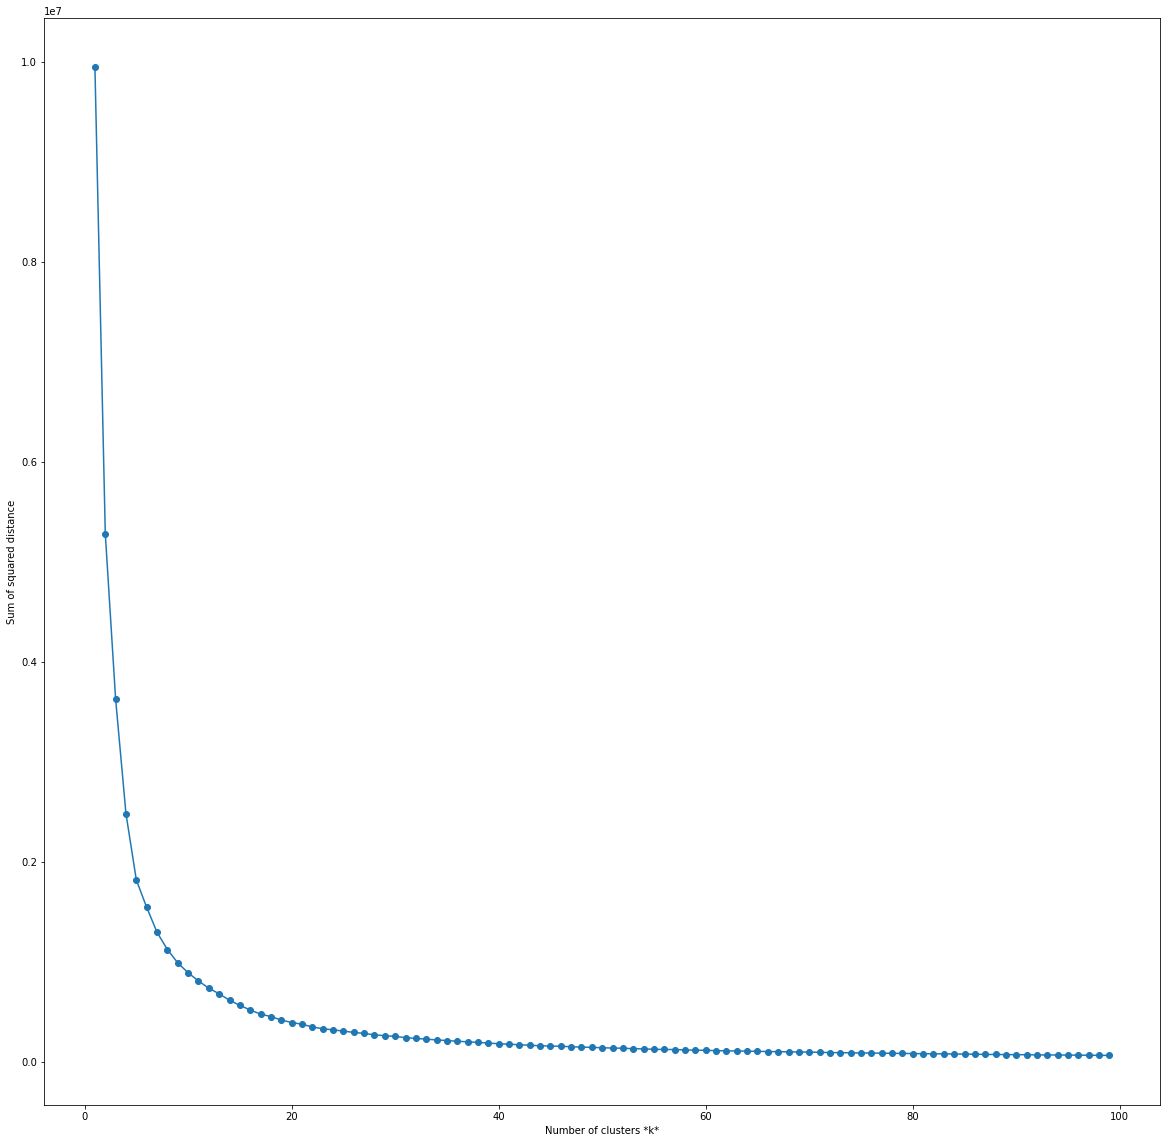

In [15]:
sse = []
list_k = list(range(1, 100))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit_predict(tsne_vct)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(20, 20))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')